In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import re


train_data = pd.read_csv("./train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


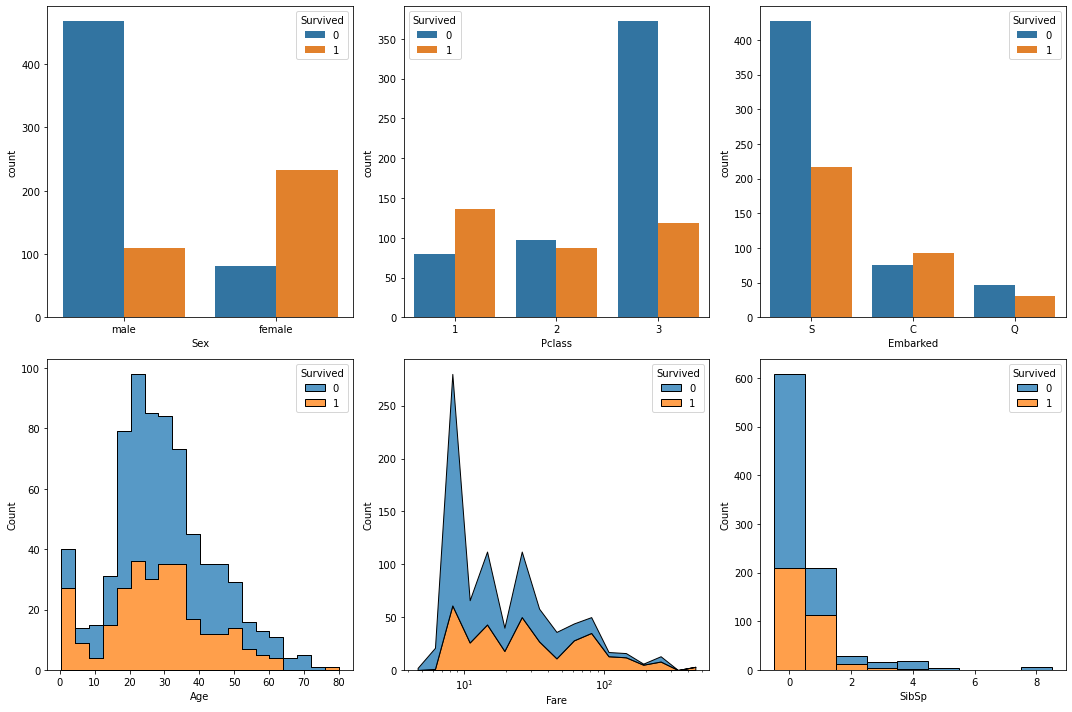

In [3]:
# Lets start by plotting a few obvious relationships between surivability and the features provided.

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))
sns.countplot(x="Sex", hue="Survived", data=train_data, ax=axs[0,0])
sns.countplot(x="Pclass", hue="Survived", data=train_data, ax=axs[0,1])
sns.countplot(x="Embarked", hue="Survived", data=train_data, ax=axs[0,2])
sns.histplot(x="Age", hue="Survived",  data=train_data, ax=axs[1,0], multiple="stack", element="step")
sns.histplot(x="Fare", hue="Survived",  data=train_data[train_data["Fare"] > 0], ax=axs[1,1], multiple="stack",  element="poly", log_scale=True)
sns.histplot(x="SibSp", hue="Survived",  data=train_data, ax=axs[1,2], multiple="stack", discrete=True, common_norm=True)

plt.tight_layout()

(0.0, 100.0)

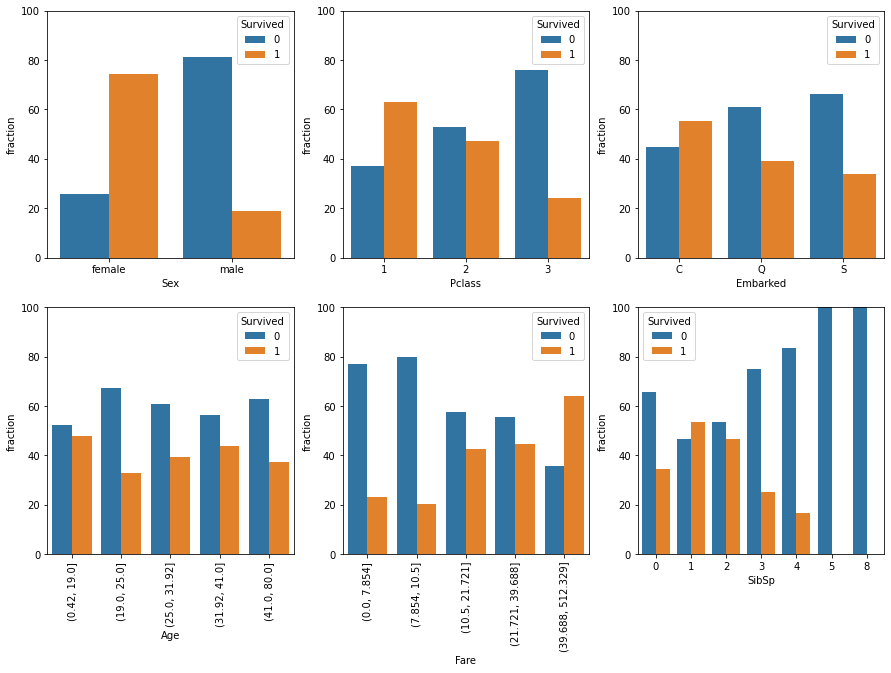

In [5]:
#Lets normalise this data so it is abit more clear for interpretation.

labels = ["Sex", "Pclass", "Embarked"]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

i= 0

for l in labels:

    grpedBy = train_data.groupby(l)["Survived"].value_counts(normalize=True).mul(100).rename('fraction').reset_index()
    o = sns.barplot(x=l, y="fraction", hue="Survived", data=grpedBy, ax=axs[0,i])
    o.set_ylim(0,100)
    i = i + 1 

    
labels =  ["Age", "Fare"]

i =0

for l in labels:
    non_zero = train_data[train_data[l].notna()]
    bin_edges = stats.mstats.mquantiles(non_zero[l], [0, 0.2, 0.4, 0.6, 0.8, 1])
    grpedBy = (non_zero.groupby(pd.cut(non_zero[l], bin_edges))["Survived"]
    .value_counts(normalize=True)
    .mul(100)
    .rename('fraction')
    .reset_index())

    o = sns.barplot(x=l, y="fraction", hue="Survived", data=grpedBy, ax=axs[1,i])
    o.set_ylim(0,100)
        
    for x in o.get_xticklabels():
        x.set_rotation(90)
    
    i = i + 1 
    
    
    
grpedBy = (non_zero.groupby("SibSp")["Survived"]
    .value_counts(normalize=True)
    .mul(100)
    .rename('fraction')
    .reset_index())

o = sns.barplot(x="SibSp", y="fraction", hue="Survived", data=grpedBy, ax=axs[1,2])
o.set_ylim(0,100)

In [6]:
# We can start seeing some trends here which are going to be useful to make predictions - however before we can think
# about building models we need to look at our missing data and clean it up...

print(train_data.count())
print("-----------------------------------------------")
print("% empty vals")
print((train_data.isnull().sum() / (train_data.count() + train_data.isnull().sum())).mul(100))
print("-----------------------------------------------")
print(train_data.describe())
print("-----------------------------------------------")
print(train_data.nunique())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64
-----------------------------------------------
% empty vals
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
-----------------------------------------------
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000 

In [10]:
#Lets do some feature engineering

#The titanic cabin grade related to its location with respect to the depth of the ship (A - Deck G - Bottom)
#Lets add a feature - cabin catagory - A-G + None

def GetCatbinCat(Cabin):
    if (Cabin != Cabin):
        return "None"
    else:
        cabStr = str(Cabin)
        return cabStr[0]

train_data["Cabin_Cat"] = train_data["Cabin"].apply(GetCatbinCat).astype('category')



Mr                  517
Miss                184
Mrs                 124
Master               40
Important_Person     24
Name: Title_Cat, dtype: int64


<AxesSubplot:xlabel='Cabin_Cat', ylabel='count'>

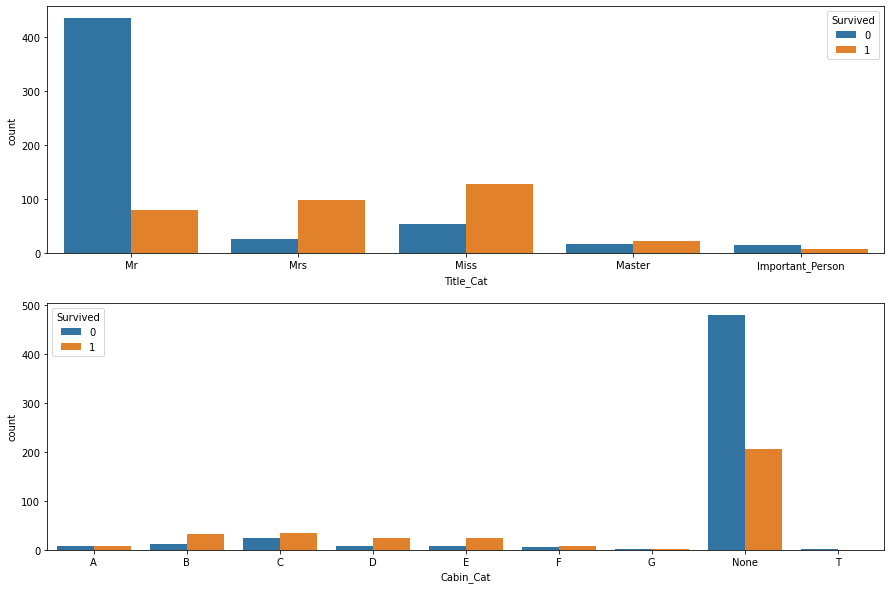

In [11]:
pattern = "(\w+)\."
def GetTitle(Name):
    return (re.findall(pattern, Name)[0])


#Lets look at the Names there could be some interesting information here...
train_data["Title"] = train_data["Name"].apply(GetTitle).astype('category')


#slightly worried about adding in noise here using the catagories with very few data points in each cat

#lets make some generalisations to remove the very sparse data < 5 count

def GeneraliseTitle(Title):
    if(Title in ["Mlle", "Ms"]):
        return "Miss"
    if(Title not in ["Mr", "Miss", "Mrs", "Master"]):
        return "Important_Person"
    return Title
    
train_data["Title_Cat"] = train_data["Title"].apply(GeneraliseTitle)


print(train_data['Title_Cat'].value_counts())


fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15,10))

sns.countplot(x="Title_Cat", hue="Survived", data=train_data, ax=axs[0])

sns.countplot(x="Cabin_Cat", hue="Survived", data=train_data, ax=axs[1])

In [12]:
train_data= train_data[train_data["Embarked"].notna()] 
# lets just ignore the three records where Embarked is not complete 
# probably not worth the effort filling in this data for now as there are so few records

#reduce variation between variables by applying MIN Max transformations
scaler = MinMaxScaler().fit(train_data[["Age", "SibSp", "Parch", "Fare"]])
train_data[["Age_MinMax", "SibSp_MinMax", "Parch_MinMax", "Fare_MinMax"]] = scaler.transform(train_data[["Age", "SibSp", "Parch", "Fare"]])


train_data[["Survived", "Pclass", "Sex", "Embarked", "Cabin_Cat", "Title_Cat"]] =   train_data[["Survived", "Pclass", "Sex", "Embarked", "Cabin_Cat", "Title_Cat"]].astype('category')


#Lets use codes for the catagorical data for the purpose of training
train_data["Survived_Code"] =  train_data["Survived"].cat.codes
train_data["Pclass_Code"] =  train_data["Pclass"].cat.codes
train_data["Sex_Code"] =  train_data["Sex"].cat.codes
train_data["Embarked_Code"] =  train_data["Embarked"].cat.codes
train_data["Cabin_Cat_Code"] =  train_data["Cabin_Cat"].cat.codes
train_data["Title_Cat_Code"] =  train_data["Title_Cat"].cat.codes

print(train_data.dtypes)

PassengerId          int64
Survived          category
Pclass            category
Name                object
Sex               category
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked          category
Cabin_Cat         category
Age_MinMax         float64
SibSp_MinMax       float64
Parch_MinMax       float64
Fare_MinMax        float64
Title             category
Title_Cat         category
Survived_Code         int8
Pclass_Code           int8
Sex_Code              int8
Embarked_Code         int8
Cabin_Cat_Code        int8
Title_Cat_Code        int8
dtype: object


In [13]:
#We have alot of missing data for Age - lets create an ensamble of weak learners which we can use to predict age for 
#missing data points. 

def GetModelScore(meth, xtrain, ytrain, xtest, ytest):
    s = 0
    if (meth == "LG"):
        model = LinearRegression()
    if(meth == "SVR"):
        model = SVR()
    if(meth == "SGD"):
        model = linear_model.SGDRegressor(max_iter = 1000,penalty = "L2",loss = 'huber',tol = 1e-3, average = True)  
    if(meth == "RIDGE"):
        model = Ridge()
    
    model.fit(xtrain,ytrain)
    
    ypredicted = model.predict(xtest)
    s = r2_score(ytest, ypredicted)
    
    return s

#lets make a prediction for the age of users based of the other available data here. 
AgeData = train_data[train_data["Age"].notna()]

#Initialise a range of polynomial degrees of freedom

polyScales = [1,2,3]

#Initialise a range of data-selections

colsToUse = ["Pclass_Code", "Fare_MinMax", "SibSp_MinMax", "Embarked_Code", "Sex_Code", "Title_Cat_Code", "Cabin_Cat_Code"]

dataToUse = []

for l in range(1, len(colsToUse)+ 1):
    for s in itertools.combinations(colsToUse, l):
        a = np.array(s)
        if (len(a) > 0):
            dataToUse.append(a)

#Initialse a range of Methods to try
methods = ["SVR", "LG", "SGD", "RIDGE"]


#Initialse an array of dicitonaries which contain the hyperparameters of the training

hyperparamSets = np.array([])

i = 0
j = 0
for p in polyScales:
    for d in dataToUse:
        for m in methods:
            hyperparamSets = np.append(hyperparamSets,     {
                "polyScale":p,
                "dataSet":d,
                "method": m
            })

results = np.array([])          

for hyperparams in hyperparamSets:
    
    X = np.array(AgeData[hyperparams["dataSet"]])
    y = np.array(AgeData["Age"])
    poly = PolynomialFeatures(degree=hyperparams["polyScale"])
    X_ = poly.fit_transform(X)
    

    cv = KFold(n_splits=10, shuffle=True, random_state=None)        
        
    scr = np.array([])
    for train_index, test_index in cv.split(X_):

        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scr = np.append(scr, GetModelScore(hyperparams["method"], X_train, y_train, X_test, y_test))  
        
    results = np.append(results,{"score":np.average(scr), "hyperparams":hyperparams})

bestResult = {"score": 0, "hyperparams":{}}

ModelsByScore = sorted(results, key=lambda m:m["score"], reverse=True)

for r in ModelsByScore[:10]:
    print(r)
    
    
    
#We can now take the top model parameters to train our weak learners from the list below - i.e. polynomial order to 
#perform transformation, which algorithm and which data sets to use. 

{'score': 0.3971641622895436, 'hyperparams': {'polyScale': 3, 'dataSet': array(['Pclass_Code', 'Fare_MinMax', 'SibSp_MinMax', 'Sex_Code',
       'Title_Cat_Code'], dtype='<U14'), 'method': 'RIDGE'}}
{'score': 0.3888978055455658, 'hyperparams': {'polyScale': 3, 'dataSet': array(['Pclass_Code', 'SibSp_MinMax', 'Sex_Code', 'Title_Cat_Code'],
      dtype='<U14'), 'method': 'RIDGE'}}
{'score': 0.3882948922920017, 'hyperparams': {'polyScale': 3, 'dataSet': array(['Pclass_Code', 'SibSp_MinMax', 'Sex_Code', 'Title_Cat_Code'],
      dtype='<U14'), 'method': 'LG'}}
{'score': 0.3843857489726993, 'hyperparams': {'polyScale': 3, 'dataSet': array(['Pclass_Code', 'SibSp_MinMax', 'Embarked_Code', 'Sex_Code',
       'Title_Cat_Code'], dtype='<U14'), 'method': 'RIDGE'}}
{'score': 0.38211964504845897, 'hyperparams': {'polyScale': 3, 'dataSet': array(['Pclass_Code', 'Fare_MinMax', 'SibSp_MinMax', 'Embarked_Code',
       'Sex_Code', 'Title_Cat_Code'], dtype='<U14'), 'method': 'RIDGE'}}
{'score': 0.37867182

In [14]:
#Lets also perform a grid search to find some ideal training parameters to use in our weak learners. 

colsToUse = ['Pclass_Code', 'SibSp_MinMax', 'Title_Cat_Code', 'Sex_Code']

X = np.array(AgeData[colsToUse])
y = np.array(AgeData["Age"])
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)

cv = KFold(n_splits=10, shuffle=True, random_state=None)     


model = Ridge()
    
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag','sparse_cg', 'auto']
space['alpha'] = np.linspace(0.01, 10, num=20)
space['fit_intercept'] = [True, False]
space['normalize'] = [True, False]
search = GridSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv)

result = search.fit(X_,y)

print("Ridge Grid Search Results ---------")
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print("------------------------------------")

colsToUse = ['Pclass_Code', 'SibSp_MinMax', 'Embarked_Code', 'Sex_Code']

X = np.array(AgeData[colsToUse])
y = np.array(AgeData["Age"])
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)

cv = KFold(n_splits=10, shuffle=True, random_state=None)     


model = SGDRegressor()
    
# define search space
space = dict()
space['penalty'] = ['L2', 'L1', 'elasticnet']
space['alpha'] = np.linspace(0.001, 0.05, num=20)
space['fit_intercept'] = [True, False]
space['shuffle'] = [True, False]
space['learning_rate'] = ['adaptive']
search = GridSearchCV(model, space, scoring='r2', n_jobs=-1, cv=cv)

result = search.fit(X_,y)

print("Stochastic Gradient Descent Grid Search Results ---------")
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print("------------------------------------")



Ridge Grid Search Results ---------
Best Score: 0.3389701947555402
Best Hyperparameters: {'alpha': 1.5873684210526318, 'fit_intercept': True, 'normalize': False, 'solver': 'sag'}
------------------------------------
Stochastic Gradient Descent Grid Search Results ---------
Best Score: 0.21640580145132438
Best Hyperparameters: {'alpha': 0.0035789473684210526, 'fit_intercept': True, 'learning_rate': 'adaptive', 'penalty': 'elasticnet', 'shuffle': False}
------------------------------------


In [23]:
#Lets use the an ensamble model of the top 10 models found above also using the training parameters to guess the age
#of passangers, we will take the median of the predicted results from each model, as opposed to the mean to negate
#any outliers, employing the wisdom of crowds here. 

#select top 10 models
modelsToTry = [m for m in ModelsByScore if m["score"] > 0]

def GetPredictor(meth, xtrain, ytrain):
    if (meth == "LG"):
        model = LinearRegression()
    if(meth == "SVR"):
        model = SVR()
    if(meth == "SGD"):
        model = linear_model.SGDRegressor(fit_intercept=True, penalty = "L2", alpha=0.0025)  
    if(meth == "RIDGE"):
        model = Ridge(solver='sag', fit_intercept=True, alpha=1.5, normalize=False)
    
    model.fit(xtrain,ytrain)
    
    return model


X_ToPredict = train_data[train_data["Age"].isna()] 
Y_Prediction = []
TrainedAgePredictors = []

i =0
for m in modelsToTry:
    colsToUse = m["hyperparams"]["dataSet"]
    X = np.array(AgeData[colsToUse])
    y = np.array(AgeData["Age"])
    poly = PolynomialFeatures(degree=m["hyperparams"]["polyScale"])
    X_Train = poly.fit_transform(X)    
    X_ToPredict_T = X_ToPredict[colsToUse]    
    X_ToPredict_T = poly.fit_transform(X_ToPredict_T)    
    predictor = GetPredictor(m["hyperparams"]["method"], X_Train, y)       
    TrainedAgePredictors.append(predictor)        
    Y_Prediction.append(predictor.predict(X_ToPredict_T))   
    i = i + 1
    
    
YPreds = np.stack(Y_Prediction, axis=0)
YPreds = (np.median(YPreds, axis=0))

In [24]:
#fill in Age from predictions

i =0
for key, value in train_data[train_data["Age"].isna()]["Age"].iteritems():
    train_data.loc[key,"Age"] = YPreds[i]
    i = i + 1


In [25]:
# for any age values which have been calculated to an impossible value (<0) lets just assume the age was erroneously 
#calulated here and set the age to be the mean val. 

avg = train_data["Age"].mean()
for key, value in train_data[train_data["Age"] < 0]["Age"].iteritems():
    train_data.loc[key,"Age"] = avg

In [29]:
#Apply Min-Max transform
scaler = MinMaxScaler().fit(train_data[["Age"]])
train_data["Age_MinMax"] = scaler.transform(train_data[["Age"]])
train_data.describe()


,PassengerId,Age,SibSp,Parch,Fare,Age_MinMax,SibSp_MinMax,Parch_MinMax,Fare_MinMax,Survived_Code,Pclass_Code,Sex_Code,Embarked_Code,Cabin_Cat_Code,Title_Cat_Code
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,29.318149,0.524184,0.382452,32.096681,0.363133,0.065523,0.063742,0.062649,0.382452,1.311586,0.649044,1.535433,5.957255,2.761530
std,256.998173,13.129263,1.103705,0.806761,49.697504,0.164982,0.137963,0.134460,0.097003,0.486260,0.834700,0.477538,0.792088,2.051251,0.844594
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,22.000000,0.000000,0.000000,7.895800,0.271174,0.000000,0.000000,0.015412,0.000000,1.000000,0.000000,1.000000,7.000000,2.000000
50%,446.000000,28.378865,0.000000,0.000000,14.454200,0.351330,0.000000,0.000000,0.028213,0.000000,2.000000,1.000000,2.000000,7.000000,3.000000
75%,668.000000,36.000000,1.000000,0.000000,31.000000,0.447097,0.125000,0.000000,0.060508,1.000000,2.000000,1.000000,2.000000,7.000000,3.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,8.000000,4.000000


In [121]:
#Aquire polynomial terms to acheive a better fit for non-linear relationships between features, including cross products

colsToUse = ['Age_MinMax', 'SibSp_MinMax', 'Parch_MinMax', 'Fare_MinMax']

X = np.array(train_data[colsToUse])
poly = PolynomialFeatures(degree=3)
X_ = poly.fit_transform(X)
X_New = pd.DataFrame(X_, columns = poly.get_feature_names(train_data[colsToUse].columns))

X_New.describe()


,1,Age_MinMax,SibSp_MinMax,Parch_MinMax,Fare_MinMax,Age_MinMax^2,Age_MinMax SibSp_MinMax,Age_MinMax Parch_MinMax,Age_MinMax Fare_MinMax,SibSp_MinMax^2,...,SibSp_MinMax^3,SibSp_MinMax^2 Parch_MinMax,SibSp_MinMax^2 Fare_MinMax,SibSp_MinMax Parch_MinMax^2,SibSp_MinMax Parch_MinMax Fare_MinMax,SibSp_MinMax Fare_MinMax^2,Parch_MinMax^3,Parch_MinMax^2 Fare_MinMax,Parch_MinMax Fare_MinMax^2,Fare_MinMax^3
count,889.0,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,...,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,1.0,0.363133,0.065523,0.063742,0.062649,0.159054,0.017655,0.019011,0.024411,0.023306,...,0.013678,0.005788,0.002441,0.003875,0.001340,0.001169,0.010363,0.002346,0.001728,0.006380
std,0.0,0.164982,0.137963,0.134460,0.097003,0.140041,0.036022,0.055621,0.044035,0.100011,...,0.091688,0.032462,0.013188,0.015072,0.006314,0.006957,0.059280,0.010700,0.011122,0.059736
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.271174,0.000000,0.000000,0.015412,0.073535,0.000000,0.000000,0.004880,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000004
50%,1.0,0.351330,0.000000,0.000000,0.028213,0.123433,0.000000,0.000000,0.008605,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022
75%,1.0,0.447097,0.125000,0.000000,0.060508,0.199896,0.029184,0.000000,0.026200,0.015625,...,0.001953,0.000000,0.000543,0.000000,0.000000,0.000123,0.000000,0.000000,0.000000,0.000222
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.311541,0.535059,0.447097,1.000000,...,1.000000,0.333333,0.135753,0.125000,0.064168,0.098820,1.000000,0.228152,0.175680,1.000000


In [122]:
#Combine all the data including polynomial terms

train_data_new = pd.concat([train_data,X_New.drop(columns=colsToUse)], axis =1)

train_data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   PassengerId                            889 non-null    float64 
 1   Survived                               889 non-null    category
 2   Pclass                                 889 non-null    category
 3   Name                                   889 non-null    object  
 4   Sex                                    889 non-null    category
 5   Age                                    889 non-null    float64 
 6   SibSp                                  889 non-null    float64 
 7   Parch                                  889 non-null    float64 
 8   Ticket                                 889 non-null    object  
 9   Fare                                   889 non-null    float64 
 10  Cabin                                  202 non-null    object 

In [123]:
#Now we have out polynomial terms lets drop a few columns which wont be useful in our model

colsToRemove = ["Survived_Code", "1", "PassengerId", "Pclass", "Name", "SibSp", "Parch", "Ticket", "Fare", "Embarked", "Title", "Age", "Cabin", "Cabin_Cat", "Title_Cat", "Sex"]


data = train_data_new.drop(columns = colsToRemove)
data["Survived"]  = data["Survived"].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Survived                               889 non-null    category
 1   Age_MinMax                             889 non-null    float64 
 2   SibSp_MinMax                           889 non-null    float64 
 3   Parch_MinMax                           889 non-null    float64 
 4   Fare_MinMax                            889 non-null    float64 
 5   Pclass_Code                            889 non-null    float64 
 6   Sex_Code                               889 non-null    float64 
 7   Embarked_Code                          889 non-null    float64 
 8   Cabin_Cat_Code                         889 non-null    float64 
 9   Title_Cat_Code                         889 non-null    float64 
 10  Age_MinMax^2                           889 non-null    float64

              precision    recall  f1-score   support

           0       0.71      0.87      0.78       102
           1       0.75      0.53      0.62        76

    accuracy                           0.72       178
   macro avg       0.73      0.70      0.70       178
weighted avg       0.73      0.72      0.71       178



<Figure size 1152x504 with 0 Axes>

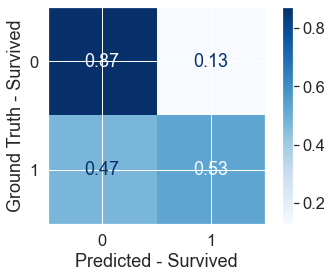

In [124]:
from sklearn.metrics import plot_confusion_matrix
#Create a random forest binary classfier to determine Survived

data = data.dropna()

X = data.drop(columns = ["Survived"])
y = data["Survived"]

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = "sqrt", max_depth=3)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)

disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize='true')

plt.xlabel('Predicted - Survived')
plt.ylabel('Ground Truth - Survived')

print(classification_report(y_test, y_pred))


                                     Gini-importance
Sex_Code                                    0.288086
Title_Cat_Code                              0.151492
Pclass_Code                                 0.107731
Fare_MinMax                                 0.106189
Cabin_Cat_Code                              0.090258
Age_MinMax                                  0.042307
SibSp_MinMax                                0.030209
Embarked_Code                               0.027244
Parch_MinMax                                0.020781
Age_MinMax^2 Fare_MinMax                    0.012515
Age_MinMax Fare_MinMax                      0.008898
Age_MinMax^3                                0.008765
Age_MinMax^2                                0.008649
Age_MinMax Fare_MinMax^2                    0.008334
Fare_MinMax^2                               0.007680
Fare_MinMax^3                               0.007401
SibSp_MinMax^2 Fare_MinMax                  0.006804
Age_MinMax Parch_MinMax Fare_MinMax         0.

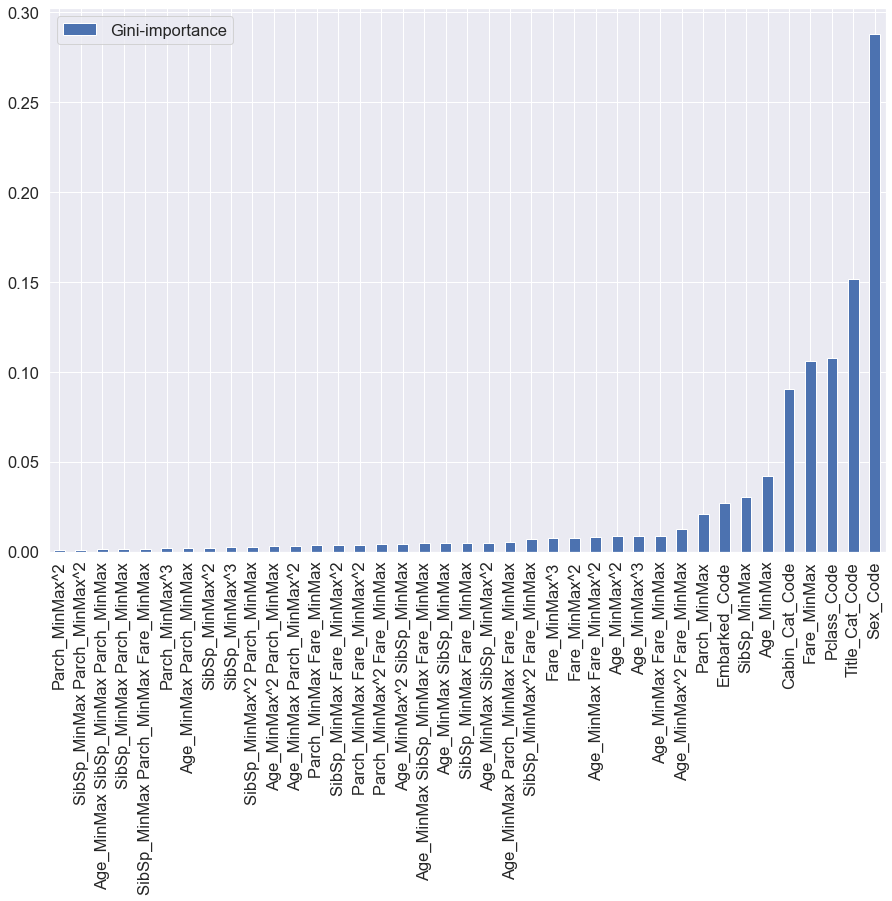

In [125]:
# note that whilst our model is accurate when making a predicting that  passanger died, however the model performed poorly
# when predicting that a passanger survived.
# lets see if we can improve these scores by narrowing down our features slightly just
# to the more important features


feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, model.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,10))

colsToUse = importances.sort_values(by='Gini-importance', ascending = False)[:20]

print(colsToUse)


In [126]:
X_ = X[colsToUse.index.values.tolist()]

              precision    recall  f1-score   support

           0       0.79      0.82      0.81       102
           1       0.75      0.71      0.73        76

    accuracy                           0.78       178
   macro avg       0.77      0.77      0.77       178
weighted avg       0.77      0.78      0.77       178



<Figure size 1152x504 with 0 Axes>

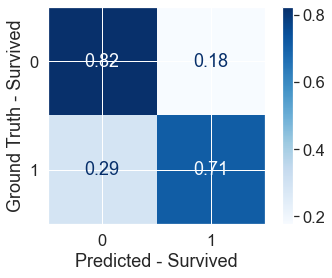

In [127]:
# lets try another decision forest but with just the top 20 most important cols

X_train, X_test,y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 42)
  
    
model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 0.5, max_depth=3)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)

disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize='true')

plt.xlabel('Predicted - Survived')
plt.ylabel('Ground Truth - Survived')

print(classification_report(y_test, y_pred))


In [128]:
#Interestingly by removing some of the features the model started behaving more evenly and the accuracy improved, this 
# this indicates the model is suffering from the curse of dimensionality, so lets run this again with fewer features,
#  15, and 10 of the most important features
from sklearn.metrics import f1_score

for i in range(1,20):
    feats[feature] = importance

    colsToUse = importances.sort_values(by='Gini-importance', ascending = False)[:i]
    X_ = X[colsToUse.index.values.tolist()]

    X_train, X_test,y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 42)
  
    
    model = RandomForestClassifier(n_estimators=1000, 
                               bootstrap = True,
                               max_features = 0.7, max_depth=3)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print("num features selected - ", i, " f1-score = ", np.sum(f1_score(y_test, y_pred, average=None)))



num features selected -  1  f1-score =  1.5142931392931396
num features selected -  2  f1-score =  1.5759039247883062
num features selected -  3  f1-score =  1.4452806418459703
num features selected -  4  f1-score =  1.5142931392931396
num features selected -  5  f1-score =  1.5374220374220375
num features selected -  6  f1-score =  1.5480910067376232
num features selected -  7  f1-score =  1.524916186570322
num features selected -  8  f1-score =  1.499656806667756
num features selected -  9  f1-score =  1.524916186570322
num features selected -  10  f1-score =  1.499656806667756
num features selected -  11  f1-score =  1.524916186570322
num features selected -  12  f1-score =  1.5123287671232877
num features selected -  13  f1-score =  1.5102201257861636
num features selected -  14  f1-score =  1.5123287671232877
num features selected -  15  f1-score =  1.522928583101814
num features selected -  16  f1-score =  1.5123287671232877
num features selected -  17  f1-score =  1.512328767123

In [129]:
#Above we can see that the number of features selected does affect the model performance, lets use the top 15 features and now perform 
#some hyperparameter tuning to determine the optimal configuration for a random forest

colsToUse = importances.sort_values(by='Gini-importance', ascending = False)[:15]
X_ = X[colsToUse.index.values.tolist()]

rfc=RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 10)]
max_features = ['sqrt']
max_depth = [int(x) for x in np.linspace(2, 10)] # keep this lower to avoid overfitting
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(2, 10,num=5)]
min_samples_leaf = [int(x) for x in np.linspace(2, 6)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 300, cv = 8, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_, y)
rf_random.best_params_


Fitting 8 folds for each of 300 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 28.9min finished


{'n_estimators': 1783,
 'min_samples_split': 4,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [112]:
#Lets compare the f1 scores for our tuned model and the base model


colsToUse = importances.sort_values(by='Gini-importance', ascending = False)[:15]
X_ = X[colsToUse.index.values.tolist()]

X_train, X_test,y_train, y_test = train_test_split(X_, y, test_size = 0.2, random_state = 42)


modelUntuned = RandomForestClassifier(n_estimators=1000, 
                           bootstrap = True,
                           max_features = 0.5, max_depth=3)

modelUntuned.fit(X_train, y_train)

y_pred_Untuned = modelUntuned.predict(X_test)

y_pred_RandomTuned = rf_random.best_estimator_.predict(X_test)

print("base f1-score = ", f1_score(y_test, y_pred_Untuned, average=None), np.sum(f1_score(y_test, y_pred_Untuned, average=None)))
print("randomly tuned f1-score = ", f1_score(y_test, y_pred_RandomTuned, average=None), np.sum(f1_score(y_test, y_pred_RandomTuned, average=None)))    

base f1-score =  [0.80382775 0.72108844] 1.524916186570322
randomly tuned f1-score =  [0.96116505 0.94666667] 1.907831715210356


In [84]:
#Tuning the parameters here show almost startiling improvements, it is wise to ensure we are avoiding overfitting,
#one way to avoid this is to invrease the number of folds being used in the cross validation, lets also hone in on the 
#parameters which were found thought the random search

param_grid = {
    'bootstrap': [False],
    'max_depth': [5,6,7,8,9,10,12,13], # the best fit seemed high so adding a low number here just incase
    'max_features': ['sqrt'],
    'min_samples_leaf': [3, 4, 5,6],
    'min_samples_split': [6,8,10, 12,14],
    'n_estimators': [100, 800, 1600, 1700, 1800, 1900, 2100, 4000]
}
    
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 8, n_jobs = -1, verbose = 2)   
grid_search.fit(X_, y)
grid_search.best_params_

y_pred_FineTuned = grid_search.best_estimator_.predict(X_test)



print("base f1-score = ", f1_score(y_test, y_pred_Untuned, average=None), np.sum(f1_score(y_test, y_pred_Untuned, average=None)))
print("randomly tuned f1-score = ", f1_score(y_test, y_pred_RandomTuned, average=None), np.sum(f1_score(y_test, y_pred_RandomTuned, average=None)))
print("fine tuned f1-score = ", f1_score(y_test, y_pred_FineTuned, average=None), np.sum(f1_score(y_test, y_pred_FineTuned, average=None)))




Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 32.2min finished


base f1-score =  [0.80769231 0.72972973] 1.5374220374220375
randomly tuned f1-score =  [0.9468599 0.9261745] 1.8730344000259378
fine tuned f1-score =  [0.93779904 0.91156463] 1.8493636689125412


Text(0, 0.5, 'Ground Truth - Survived')

<Figure size 1152x504 with 0 Axes>

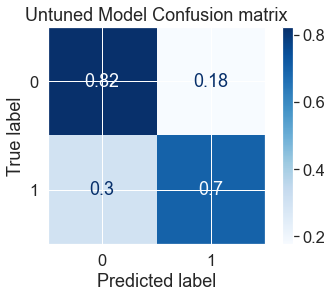

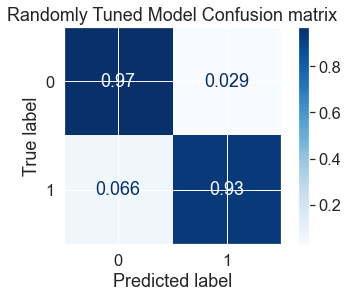

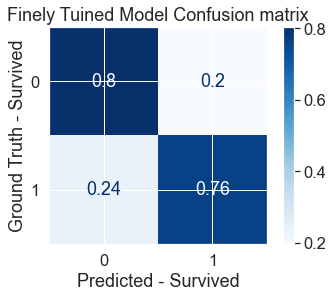

In [113]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.5)

options = [("Untuned Model Confusion matrix", modelUntuned),
                  ("Randomly Tuned Model Confusion matrix", rf_random.best_estimator_),
                  ("Finely Tuined Model Confusion matrix", grid_search.best_estimator_)
                 ]
for title, model in options:
    disp = plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title(title)


plt.xlabel('Predicted - Survived')
plt.ylabel('Ground Truth - Survived')

In [114]:
#looks like further tuning of hyperparameters will provide no real improvement 
#lets use the randomly tuned model since this model has the best f1 score. 
#Lets go import the test data, perform the necessary transformations and retrieve the csv results to submit


X_ToEval = pd.read_csv("./Test.csv ")

X_ToEval["Cabin_Cat"] = X_ToEval["Cabin"].apply(GetCatbinCat).astype('category')


#Lets look at the Nmes there could be some interesting information here...
X_ToEval["Title"] = X_ToEval["Name"].apply(GetTitle).astype('category')

X_ToEval["Title_Cat"] = train_data["Title"].apply(GeneraliseTitle)


#reduce variation between variables by applying MIN Max transformations
scaler = MinMaxScaler().fit(X_ToEval[["Age", "SibSp", "Parch", "Fare"]])
X_ToEval[["Age_MinMax", "SibSp_MinMax", "Parch_MinMax", "Fare_MinMax"]] = scaler.transform(X_ToEval[["Age", "SibSp", "Parch", "Fare"]])

X_ToEval[["Pclass", "Sex", "Embarked", "Cabin_Cat", "Title_Cat"]] =   X_ToEval[["Pclass", "Sex", "Embarked", "Cabin_Cat", "Title_Cat"]].astype('category')

X_ToEval["Pclass_Code"] =  X_ToEval["Pclass"].cat.codes
X_ToEval["Sex_Code"] =  X_ToEval["Sex"].cat.codes
X_ToEval["Embarked_Code"] =  X_ToEval["Embarked"].cat.codes
X_ToEval["Cabin_Cat_Code"] =  X_ToEval["Cabin_Cat"].cat.codes
X_ToEval["Title_Cat_Code"] =  X_ToEval["Title_Cat"].cat.codes

In [115]:
X_ToPredict = X_ToEval[X_ToEval["Age"].isna()] 
Y_Prediction = [] 

Y_Preds = []
i =0
for m in modelsToTry:
    colsToUse = m["hyperparams"]["dataSet"]
    X = np.array(AgeData[colsToUse])
    y = np.array(AgeData["Age"])
    poly = PolynomialFeatures(degree=m["hyperparams"]["polyScale"])
    X_Train = poly.fit_transform(X)    
    X_ToPredict_T = X_ToPredict[colsToUse]    
    X_ToPredict_T = poly.fit_transform(X_ToPredict_T)    
    Y_Prediction.append(TrainedAgePredictors[i].predict(X_ToPredict_T))
    i = i + 1

    
YPreds = np.stack(Y_Prediction, axis=0 )
YPreds = (np.median(YPreds, axis=0))
    
i =0
for key, value in X_ToEval[X_ToEval["Age"].isna()]["Age"].iteritems():
    X_ToEval.loc[key,"Age"] = YPreds[i]
    i = i + 1
    
    
avg = X_ToEval["Age"].mean()
for key, value in X_ToEval[X_ToEval["Age"] < 0]["Age"].iteritems():
    X_ToEval.loc[key,"Age"] = avg
    
scaler = MinMaxScaler().fit(X_ToEval[["Age"]])
X_ToEval["Age_MinMax"] = scaler.transform(X_ToEval[["Age"]])

avg = X_ToEval["Fare_MinMax"].mean()
for key, value in X_ToEval[X_ToEval["Fare_MinMax"].isna()]["Fare_MinMax"].iteritems():
    X_ToEval.loc[key,"Fare_MinMax"] = avg

In [116]:
colsToUse = ['Age_MinMax', 'SibSp_MinMax', 'Parch_MinMax', 'Fare_MinMax']
X = np.array(X_ToEval[colsToUse])
poly = PolynomialFeatures(degree=3)
X_ = poly.fit_transform(X)
X_New = pd.DataFrame(X_, columns = poly.get_feature_names(X_ToEval[colsToUse].columns))

X_ToEval_new = pd.concat([X_ToEval,X_New.drop(columns=colsToUse)], axis =1)

colsToRemove = ["1", "PassengerId", "Pclass", "Name", "SibSp", "Parch", "Ticket", "Fare", "Embarked", "Title", "Age", "Cabin", "Cabin_Cat", "Title_Cat", "Sex"]

data = X_ToEval_new.drop(columns = colsToRemove)

colsToUse = importances.sort_values(by='Gini-importance', ascending = False)[:15]

X_ToEval_new = X_ToEval_new[colsToUse.index.values.tolist()]

Y_Preds = modelUntuned.predict(X_ToEval_new)

In [117]:
X_ToEval["Survived"] = Y_Preds

In [118]:
X_ToEval[["PassengerId","Survived"]]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
X_ToEval[["PassengerId","Survived"]].to_csv('final_out.csv', index=False, encoding='utf-8')